In [1]:
import datetime

import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
import seaborn_image as isns

In [3]:
comnist_data = np.loadtxt('./../datasets/latin_data.csv', delimiter=",", dtype="float32")
comnist_label = np.loadtxt('./../datasets/latin_label.csv', delimiter=",", dtype="float32")

In [ ]:
import string

i = np.random.randint(comnist_data.shape[0])
my_letter = np.flip(comnist_data[i].reshape(28, 28), 0)
my_label = string.ascii_uppercase[int(comnist_label[i])]
print(f"Displaying letter {my_label}")
isns.imgplot(my_letter, cmap="gray", describe=True)

In [4]:
import os
from torch.utils.data import Dataset
from torchvision.io import read_image


class СoMNISTDataset(Dataset):
    def __init__(
        self,
        labels_dir,
        data_dir,
        transform=None,
        target_transform=None
    ):
        self.img_labels = pd.read_csv(labels_dir)
        self.img_features = pd.read_csv(data_dir)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = np.asarray(self.img_features.iloc[idx], dtype=np.float32).reshape(28,28)
        label = self.img_labels.iloc[idx, 0]

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [5]:
import torchvision.transforms.functional


training_samples: 128
validation_samples: 12693

0


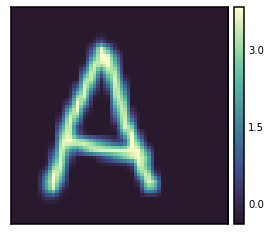

In [8]:
comnnist_dataset = СoMNISTDataset(
    labels_dir='./../datasets/latin_label.csv',
    data_dir='./../datasets/latin_data.csv',
    transform=transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((64,64)),
        transforms.functional.vflip,
        transforms.ToTensor(),
        transforms.Normalize(mean=0.0942,
                             std=0.2352)
    ])
)
training_samples = int(len(comnnist_dataset) * 0.01)
validation_samples = len(comnnist_dataset) - training_samples
print(f'''
training_samples: {training_samples}
validation_samples: {validation_samples}
''')

isns.imshow(comnnist_dataset[100][0].squeeze(0))
print(comnnist_dataset[100][1])

In [ ]:
image = comnnist_dataset[100][0]
plt.imshow(image.permute(1, 2 ,0))

In [ ]:
imgs = torch.stack([img_t for img_t, _ in comnnist_dataset], dim=3)
imgs.shape

In [ ]:
imgs.view(1, -1).mean(dim=1)

In [ ]:
imgs.view(1, -1).std(dim=1)

In [9]:
train_set, val_set = torch.utils.data.random_split(
    comnnist_dataset,
    [training_samples, validation_samples],
    generator=torch.Generator().manual_seed(42))

In [28]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)

In [ ]:
data_i = iter(train_loader)
images, labels = data_i.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(string.ascii_uppercase[int(labels[idx].item())])

In [ ]:
img = np.squeeze(images[0])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max() / 2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y], 2) if img[x][y] != 0 else 0
        ax.annotate(str(val), xy=(y, x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y] < thresh else 'black')




In [30]:
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
class Net(nn.Module):
    def __init__(self, n_out=26):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, n_out)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)

        return out

# initialize the NN
model = Net()
print(model)

In [29]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 26, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [14]:
img, _ = comnnist_dataset[0]
img_batch = img.unsqueeze(0)



<AxesSubplot:>

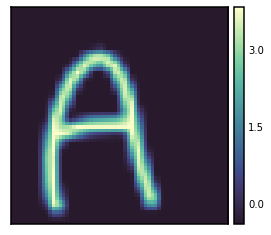

In [23]:
isns.imshow(img.permute(1,2,0))

In [31]:
alexnet = AlexNet()
out = alexnet(img.unsqueeze(0))
out

tensor([[ 0.0093,  0.0042, -0.0103,  0.0030, -0.0287, -0.0125,  0.0075, -0.0174,
         -0.0064,  0.0152,  0.0158, -0.0058,  0.0084, -0.0046, -0.0107, -0.0262,
         -0.0073,  0.0009, -0.0189,  0.0001, -0.0042, -0.0100, -0.0089,  0.0069,
         -0.0145, -0.0085]], grad_fn=<AddmmBackward>)

In [ ]:
out = model(img.unsqueeze(0))
out

In [26]:
## Specify loss and optimization functions

# specify loss function
loss_fn = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.Adam(alexnet.parameters(), lr=1e-5)

In [27]:
n_epochs = 200

alexnet.train()

for epoch in range(n_epochs):
    loss_train = 0.0
    # loss_val = 0.0
    # correct = 0
    # total = 0
    for images, labels in train_loader:
        outputs = alexnet(images)
        train_loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        loss_train += train_loss.item()

    print(f'{datetime.datetime.now()} Epoch {epoch}, Training loss {loss_train / len(train_loader)}')
    # with torch.no_grad():
    #     for images, labels in val_loader:
    #         outputs = alexnet(images)
    #         val_loss = loss_fn(outputs, labels)
    #         _, predicted = torch.max(outputs, dim=1)
    #         total += labels.shape[0]
    #         correct += int((predicted == labels).sum())
    #         loss_val += val_loss.item()

    # if epoch == 1 or epoch % 5 == 0:
    #     print(f'{datetime.datetime.now()} Epoch {epoch}, Training loss {loss_train / len(train_loader)}')
          #f', Validation loss {loss_val / len(val_loader)}, Accuracy {correct / total}')

KeyboardInterrupt: 

In [ ]:
import seaborn as sns
import pandas as pd

data = pd.DataFrame(dict(epoch=epoch_list, loss=train_loss_list))
sns.set_theme(style="darkgrid")

fig = sns.relplot(
    x='epoch'
    , y='loss'
    , kind='scatter'
    , data=data
)
fig.savefig("output_3_80_relu.png")

In [ ]:

# obtain one batch of test images
dataiter = iter(val_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(
        "{} ({})".format(string.ascii_uppercase[int(preds[idx].item())],string.ascii_uppercase[int(labels[idx].item())]),
        color=("green" if preds[idx] == labels[idx] else "red"))




In [ ]:
# import torch
# torch.cuda.is_available()

In [ ]:
# torch.zeros(1).cuda()


In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()  # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item() * data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(100):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)')

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))